In [7]:
# %matplotlib qt
import numpy as np
import pandas as pd
import scipy.optimize as so
import matplotlib.pyplot as plt

Scherrer equation:

$\tau=\frac{K\lambda}{\beta cos(\theta)}$

where $K$ is a number of order unity having to do with crystallite shape, $\lambda = 1.54056 Å$ is the x-ray wavelength, $\beta$ is the FWHM of the peak, and $\theta$ is the bragg angle (_NOT_ $2\theta$!!)

In [10]:
def deg_to_rad(a):
    return a*np.pi/180

def scherrer(center, left, right, sto_fwhm):
    return 0.9*1.54056/(deg_to_rad(right-left-sto_fwhm)*np.cos(deg_to_rad(center/2)))

def scherrer_fwhm(center, fwhm, sto_fwhm):
    return 0.94*1.54056/(deg_to_rad(np.sqrt(fwhm**2-sto_fwhm**2))*np.cos(deg_to_rad(center/2)))

def lorentz(x, A, c, w, offset):
    return offset+A/(1+((c-x)/(0.5*w))**2)

def gauss(x, A, c, w, offset):
    return offset+A*np.exp((-4*np.log(2)*(x-c)**2)/(w**2))

def double_lorentz(x, A1, c1, w1, A2, c2, w2, offset):
    return lorentz(x, A1, c1, w1, 0)+lorentz(x, A2, c2, w2, 0)+offset

def pseudo_voigt(x, A, c, fwhm_g, fwhm_l, offset):
    eta_val = eta(fwhm_g, fwhm_l)
    return eta_val*lorentz(x, A, c, fwhm_l, 0)+(1-eta_val)*gauss(x, A, c, fwhm_g, 0)+offset

def eta(fwhm_g, fwhm_l):
    fwhm_total = (fwhm_g**5 + 2.69269*(fwhm_g**4)*(fwhm_l) + 2.42843*(fwhm_g**3)*(fwhm_l**2) + 4.47163*(fwhm_g**2)*(fwhm_l**3) + 0.07842*(fwhm_g)*(fwhm_l**4) + fwhm_l**5)**0.2
    return 1.36603*(fwhm_l/fwhm_total) - 0.47719*((fwhm_l/fwhm_total)**2) + 0.11116*((fwhm_l/fwhm_total)**3)

In [9]:
data = pd.read_csv('C:/Users/pdmurray/Desktop/peyton/Projects/YBCO_Getters/Data/Combined Datasets/XRD.csv',
                   names=['ag_tth', 'ag_i', '3nm_tth', '3nm_i', '7nm_tth', '7nm_i', '20nm_tth', '20nm_i', 'ta_tth', 'ta_i'],
                   skiprows=2)

c:\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
c:\python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


     fun: 31317.13942439652
 message: 'Optimization terminated successfully.'
    nfev: 5865
     nit: 47
 success: True
       x: array([5.01666251e+02, 1.51610368e+01, 9.92525954e-02, 4.73163610e-01])
------
     fun: 106862.69707911191
     jac: array([-206.63428586,    4.31464287,  -85.24511941,    1.27329258])
 message: 'Optimization terminated successfully.'
    nfev: 5720
     nit: 46
 success: True
       x: array([9.99720648e+02, 1.51112453e+01, 8.41640955e-02, 7.31133220e+00])
------
     fun: 18904.498934203788
 message: 'Optimization terminated successfully.'
    nfev: 4425
     nit: 35
 success: True
       x: array([1.77862620e+02, 1.50602024e+01, 1.63260731e-01, 6.47876164e+00])
------
     fun: 149931.0342965777
     jac: array([ -0.06111804,  -6.31844159, -48.20467439,   0.07275958])
 message: 'Optimization terminated successfully.'
    nfev: 3845
     nit: 30
 success: True
       x: array([411.77513939,  14.47652589,   0.61007778,   9.67786268])
------


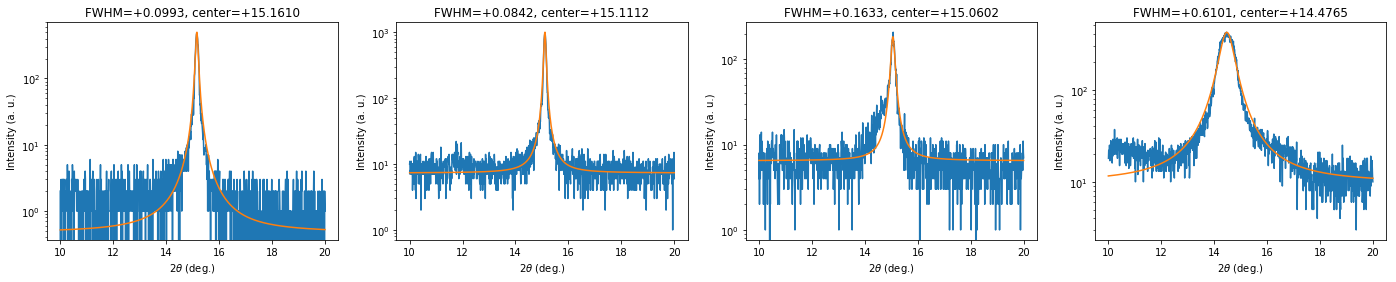

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,4))

fwhm_film = {}
fwhm_sto = {}
center_film = {}
center_film_uncertainty = {}
fwhm_film_uncertainty = {}

for index, tth, i, key in zip([0,1,2,3], ['ag_tth', '3nm_tth', '7nm_tth', '20nm_tth'], ['ag_i', '3nm_i', '7nm_i', '20nm_i'], ['ag', '3nm', '7nm', '20nm']):
    mask = np.logical_and(data[tth] <= 20, data[tth] >= 10)
    x = data[tth][mask].values
    y = data[i][mask].values

#     popt, pcov = so.curve_fit(lorentz, x, y, p0=[1e3, 15, 0.5, 10], bounds=([0, 10, 0, 0], [1e3, 20, 1, 1e3]))
    res = so.differential_evolution(lambda pars: np.sum((lorentz(x, *pars) - y)**2), bounds=((0, 1e3), (10,20), (0,1), (0,1e3)), popsize=30)
    popt = res.x
    print(res)
#     jacobian = res.jac
#     print(res)
#     pcov = np.linalg.inv(res.jac.T@res.jac)
#     print(jacobian.T@jacobian)
#     print(pcov)
    print('------')
    
    x_fit = np.linspace(10,20,1000)
    y_fit = lorentz(x_fit, *popt)

    ax[index].plot(data[tth][mask], data[i][mask])
    ax[index].plot(x_fit, y_fit)
    ax[index].set_title('FWHM={:+4.4f}, center={:+4.4f}'.format(popt[2], popt[1]))
    ax[index].set_xlabel('$2\\theta$ (deg.)')
    ax[index].set_ylabel('Intensity (a. u.)')
    ax[index].set_yscale('log', nonposy='clip')
    
    center_film[key] = popt[1]
    fwhm_film[key] = popt[2]
    
#     MSE = np.sqrt(np.diag(pcov))
    
#     center_film_uncertainty[key] = MSE[1]
#     fwhm_film_uncertainty[key] = MSE[2]
    
# print(center_film_uncertainty)
# print(fwhm_film_uncertainty)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

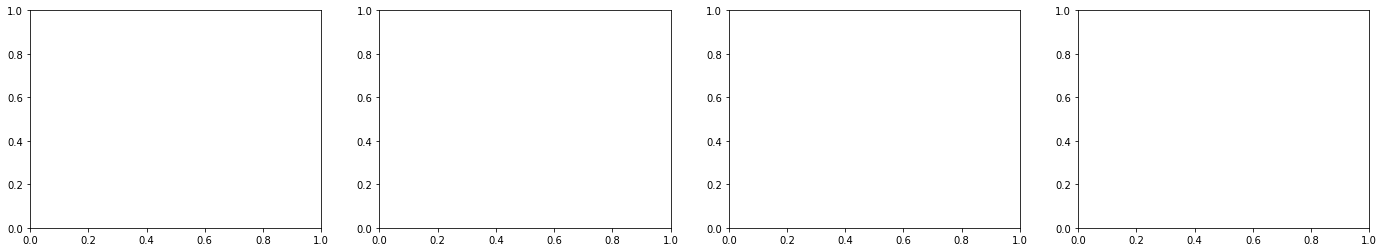

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24,4))
for index, tth, i, key in zip([0,1,2,3], ['ag_tth', '3nm_tth', '7nm_tth', '20nm_tth'], ['ag_i', '3nm_i', '7nm_i', '20nm_i'], ['ag', '3nm', '7nm', '20nm']):
    mask = np.logical_and(data[tth] <= 24, data[tth] >= 21)
    x = data[tth][mask].values
    y = data[i][mask].values

#     res = so.differential_evolution(lambda pars: np.sum((lorentz(x, *pars) - y)**2), bounds=((1e3, 1e7), (21,24), (0.01,0.5), (0,10)), popsize=30)
    popt, pcov = so.curve_fit(lorentz, x, y, p0=[1e5, 22.5, 0.01, 1], bounds=([1e3, 22.5, 0.01, 0], [1e7, 23, 0.5, 10]), method='trf', max_nfev=1e3)

    x_fit = np.linspace(21,24,1000)
    y_fit = lorentz(x_fit, *popt)

    ax[index].plot(data[tth][mask], data[i][mask])
    ax[index].plot(x_fit, y_fit, color='orange')
#     ax[index].set_title('FWHM={:+4.4f}, center={:+4.4f}'.format(popt[2], popt[1]))
    ax[index].set_xlabel('$2\\theta$ (deg.)')
    ax[index].set_ylabel('Intensity (a. u.)')
    ax[index].set_yscale('log', nonposy='clip')
    
#     fwhm_sto[key] = popt[2]
#     fwhm_sto_uncertainty[key] = np.sqrt(np.diag(pcov))[2]

In [59]:
scherrer_size = {}
scherrer_size_uncertainty = {}

for key in center_film.keys():
    scherrer_size[key] = scherrer_fwhm(center=center_film[key], fwhm=fwhm_film[key], sto_fwhm=fwhm_sto[key])
    scherrer_size_uncertainty[key]

scherrer_sizes = {key: scherrer_fwhm(center=center_film[key], fwhm=fwhm_film[key], sto_fwhm=fwhm_sto[key]) for key in center_film.keys()}

In [60]:
fwhm_film

{'ag': 0.09916357307279819,
 '3nm': 0.0849059010032871,
 '7nm': 0.16501604550610083,
 '20nm': 0.6100809094915213}

In [61]:
center_film

{'ag': 15.160870996615282,
 '3nm': 15.111536823129612,
 '7nm': 15.060428283891499,
 '20nm': 14.476525972814201}

In [62]:
fwhm_sto

{'ag': 0.01826402106538987,
 '3nm': 0.027540584456589808,
 '7nm': 0.03341619147674249,
 '20nm': 0.019799193144103392}

In [63]:
scherrer_sizes

{'ag': 858.7823301568224,
 '3nm': 1042.1224650877034,
 '7nm': 517.9131423876039,
 '20nm': 137.1656435020369}

Text(0, 0.5, 'Scherrer size')

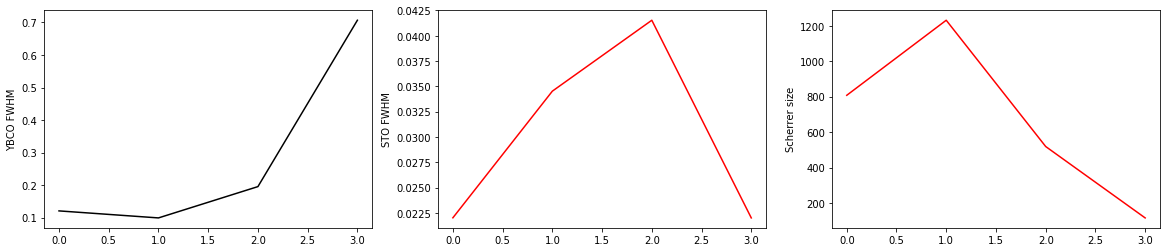

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax[0].plot([value for key, value in fwhm_film.items()], '-k', label='FWHM YBCO')
ax[0].set_ylabel('YBCO FWHM')
ax[1].plot([value for key, value in fwhm_sto.items()], '-r', label='FWHM STO')
ax[1].set_ylabel('STO FWHM')
ax[2].plot([value for key, value in scherrer_sizes.items()], '-r', label='Scherrer sizes')
ax[2].set_ylabel('Scherrer size')

c:\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


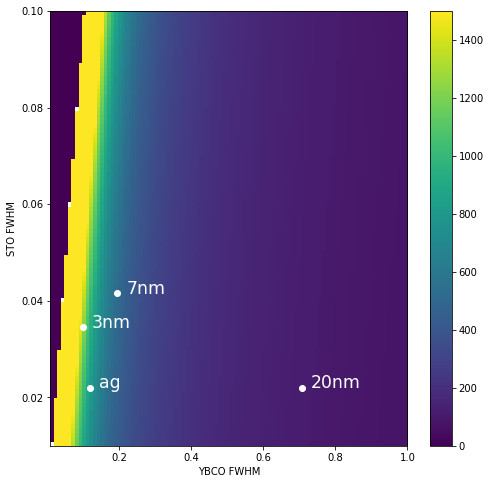

In [44]:
_ybco_fwhm_v = np.linspace(0.01, 1, 100)
_sto_fwhm_v = np.linspace(0.01, 0.1, 100)

_ybco_fwhm, _sto_fwhm = np.meshgrid(_ybco_fwhm_v, _sto_fwhm_v)

xwidth = np.max(_ybco_fwhm)-np.min(_ybco_fwhm)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(scherrer_fwhm(15, _ybco_fwhm, _sto_fwhm), cmap='viridis',aspect='auto', origin='lower', interpolation='nearest', extent=[np.min(_ybco_fwhm), np.max(_ybco_fwhm), np.min(_sto_fwhm), np.max(_sto_fwhm)], vmin=0, vmax=1500)
for key in fwhm_film.keys():
    ax.plot(fwhm_film[key], fwhm_sto[key], 'ow')
    ax.text(fwhm_film[key]+0.025*xwidth, fwhm_sto[key], '{}'.format(key), size='xx-large', color='white')
ax.set_xlabel('YBCO FWHM')
ax.set_ylabel('STO FWHM')
fig.colorbar(im)

In [34]:
def de_fit(tth, intensity, xmin, xmax):
    mask = np.logical_and(tth <= xmax, tth >= xmin)
    x = tth[mask]
    y = intensity[mask]

    res = so.differential_evolution(lambda pars: np.sum((lorentz(x, *pars) - y)**2), bounds=((1e3, 1e6), (xmin, xmax), (0.0001, 0.5), (0,10)), popsize=30)
    x_fit = np.linspace(21,24,1000)
    y_fit = lorentz(x_fit, *res.x)
    return res.x

def williamson_hall(tth, intensity):
    
    # Center, fwhm
    c = []
    w = []
    
    # YBCO (002)
    result = de_fit(tth, intensity, 10, 20)
    c.append(result[1])
    w.append(result[2])
    x_002 = np.linspace(10, 20, 1000) 
    y_002 = lorentz(x_002, *result)
    
    # YBCO (004)
    result = de_fit(tth, intensity, 28, 32)
    c.append(result[1])
    w.append(result[2])
    x_004 = np.linspace(28, 32, 1000) 
    y_004 = lorentz(x_004, *result)
    
    # YBCO (007)
    result = de_fit(tth, intensity, 52, 58)
    c.append(result[1])
    w.append(result[2])
    x_007 = np.linspace(52, 58, 1000) 
    y_007 = lorentz(x_007, *result)
    
    c = np.array(c)
    w = np.array(w)
    
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(tth, intensity)
    ax1.plot(x_002, y_002, color='orange')
    ax1.plot(x_004, y_004, color='orange')
    ax1.plot(x_007, y_007, color='orange')
    ax1.set_yscale('log', nonposy='clip')
    ax1.set_xlim(10,60)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(np.cos(c/2), w*np.sin(c/2), 'ok')
    return

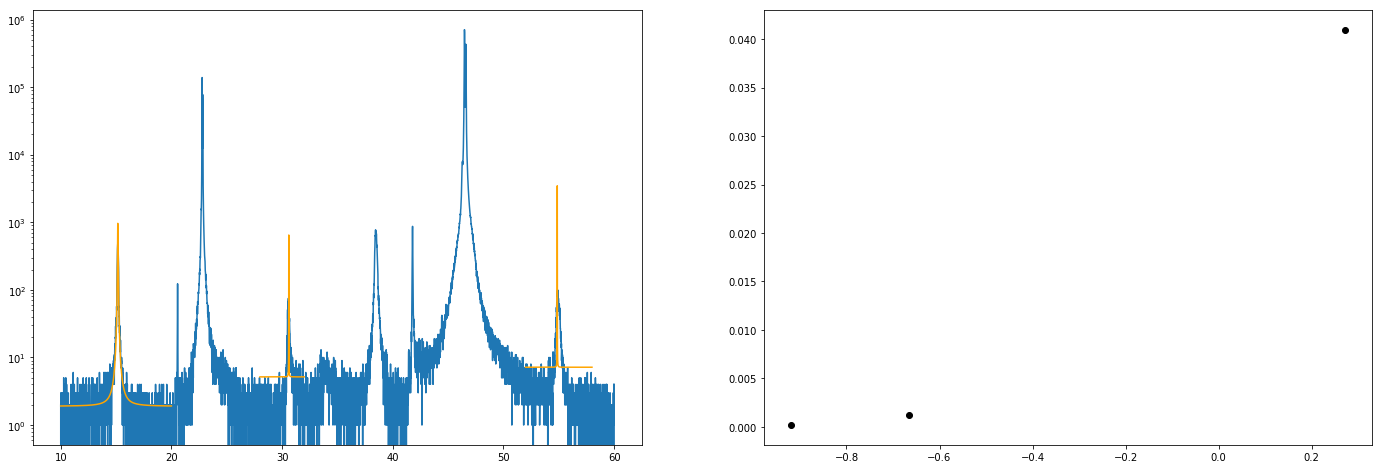

In [35]:
williamson_hall(data['ag_tth'], data['ag_i'])